# Домашнее задание к занятию 2.1: Деревья решений. Классификация

ДАНИЛЬЧЕНКО ВАДИМ

KAGGLE COMPETITION 

https://www.kaggle.com/c/titanic/overview

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC

In [133]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [81]:
train_df=pd.read_csv('data/titanic/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [149]:
test_df=pd.read_csv('data/titanic/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [84]:
miss=train_df[train_df['Name'].str.contains('Miss. ')].index.tolist()
mr=train_df[((train_df['Name'].str.contains('Mr. '))|(train_df['Name'].str.contains('Mr ')))\
      &(~train_df['Name'].str.contains('Mrs. '))].index.tolist()
mrs=train_df[train_df['Name'].str.contains('Mrs. ')].index.tolist()
others=train_df[(~train_df['Name'].str.contains('Mr'))&(~train_df['Name'].str.contains('Mrs'))\
      &(~train_df['Name'].str.contains('Miss'))].index.tolist()

In [85]:
# Функция вернет титул
def check_title(text):
    if 'Mr ' in text or 'Mr. ' in text:
        return 'Mr'
    elif 'Miss. ' in text:
        return 'Miss'
    elif 'Mrs. ' in text:
        return 'Mrs'
    else:
        return 'Others'

In [86]:
train_df['title']=train_df.Name.apply(check_title)

In [87]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [88]:
# посмотрим какие столбцы у нас категориальные
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
title          891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [89]:
# заменим на медиану пропуски в возрасте
# train.Age.fillna(train.Age.median(), inplace=True)
train_df.dropna(subset=['Age'], inplace=True)

In [164]:
# посмотрим на распределение пассажирова по полю "Parch"
train_df.Parch.value_counts(normalize=True)

0    0.729692
1    0.154062
2    0.095238
5    0.007003
3    0.007003
4    0.005602
6    0.001401
Name: Parch, dtype: float64

In [166]:
# объединим Parch
def group_Parch(value):
    if value==0:
        return '0'
    elif value==1:
        return '1'
    elif value==2:
        return '2'
    else:
        return 'other'
train_df['Parch_cat']=train_df.Parch.apply(group_Parch)

In [169]:
# посмотрим на распределение пассажирова по полю "SibSp"
train_df.SibSp.value_counts(normalize=True)

0    0.659664
1    0.256303
2    0.035014
4    0.025210
3    0.016807
5    0.007003
Name: SibSp, dtype: float64

In [170]:
# объединим SibSp
def group_SibSp(value):
    if value==0:
        return '0'
    elif value==1:
        return '1'
    else:
        return 'other'
train_df['SibSp_cat']=train_df.SibSp.apply(group_SibSp)

In [172]:
# преобразуем в категориальную переменную

temp_df=train_df[['Sex', 'Embarked','Pclass', 'SibSp_cat', 'Parch_cat']].copy()
temp_df['Pclass']=temp_df['Pclass'].astype(object)
temp_df['SibSp_cat']=temp_df['SibSp_cat'].astype(object)
temp_df['Parch_cat']=temp_df['Parch_cat'].astype(object)
temp_df=pd.get_dummies(temp_df)
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 15 columns):
Sex_female         714 non-null uint8
Sex_male           714 non-null uint8
Embarked_C         714 non-null uint8
Embarked_Q         714 non-null uint8
Embarked_S         714 non-null uint8
Pclass_1           714 non-null uint8
Pclass_2           714 non-null uint8
Pclass_3           714 non-null uint8
SibSp_cat_0        714 non-null uint8
SibSp_cat_1        714 non-null uint8
SibSp_cat_other    714 non-null uint8
Parch_cat_0        714 non-null uint8
Parch_cat_1        714 non-null uint8
Parch_cat_2        714 non-null uint8
Parch_cat_other    714 non-null uint8
dtypes: uint8(15)
memory usage: 16.0 KB


In [173]:
y_train=train_df.Survived.copy()
train=pd.concat([train_df[['PassengerId', 'Age', 'Fare']], temp_df], axis=1)

In [174]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
depths = np.arange(10,100)
samples_leaf = np.arange(1,10)
features_num = np.arange(5,train.shape[1])
min_samplest = np.arange(2,10)
grid = {'max_depth': depths, 'min_samples_leaf': samples_leaf, 'min_samples_split':min_samplest}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

Wall time: 0 ns


In [175]:
%%time
gridsearch.fit(train, y_train)

Wall time: 40.6 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n...
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76

In [176]:
# лучшие параметры
gridsearch.best_params_  

{'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 8}

In [183]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

tree=DecisionTreeClassifier(max_depth=12, min_samples_leaf=7, min_samples_split=8)
tree.fit(train, y_train)
y_train_pred=tree.predict(train)

print('precision(точность): {}'.format(precision_score(np.array(y_train), np.round(y_train_pred))))
print('recall(полнота): {}'.format(recall_score(np.array(y_train), np.round(y_train_pred))))
print('accuracy: {}'.format(accuracy_score(np.array(y_train), np.round(y_train_pred))))
print('f1 score: {}'.format(f1_score(y_train, np.round(y_train_pred))))

precision(точность): 0.8807692307692307
recall(полнота): 0.7896551724137931
accuracy: 0.8711484593837535
f1 score: 0.8327272727272726


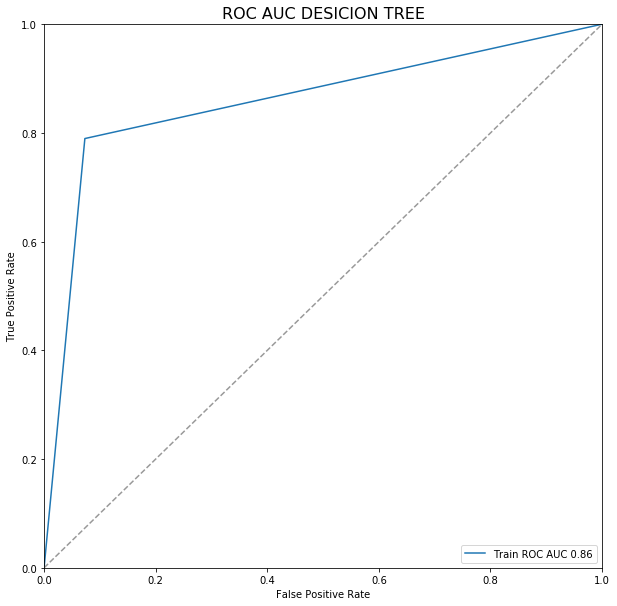

In [184]:
# визуализируем построим график ROC AUC кривой

import matplotlib.pyplot as plt
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
roc_auc_train = np.round(roc_auc_score(y_train, y_train_pred), 2)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC DESICION TREE', size=16)
plt.legend(loc='lower right')
plt.show()

<BarContainer object of 18 artists>

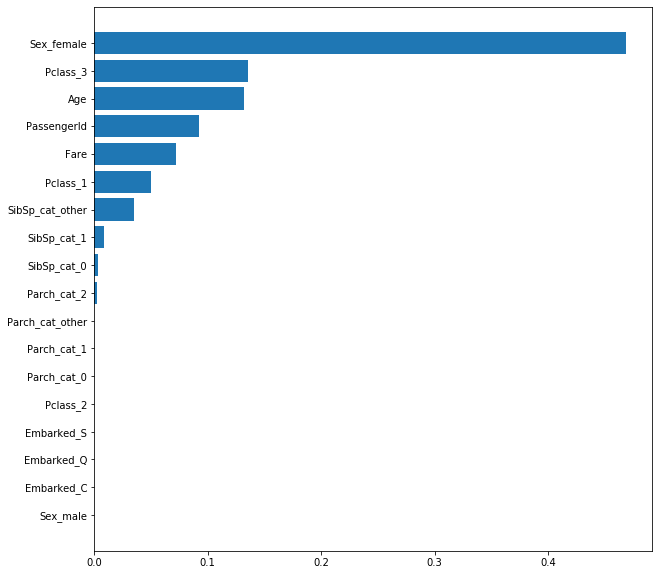

In [230]:
importances=zip(train.columns,tree.feature_importances_)
importances=pd.DataFrame(sorted(importances, key=lambda kv: kv[1]))
plt.barh(importances.iloc[:,0], importances.iloc[:,1])

мы видим, что на выживание в первую чередь оказал пол пассажира, 3й класс и возраст (хоть и не можем утверждать в какую сторону)

### нарисуем полученное дерево решений 

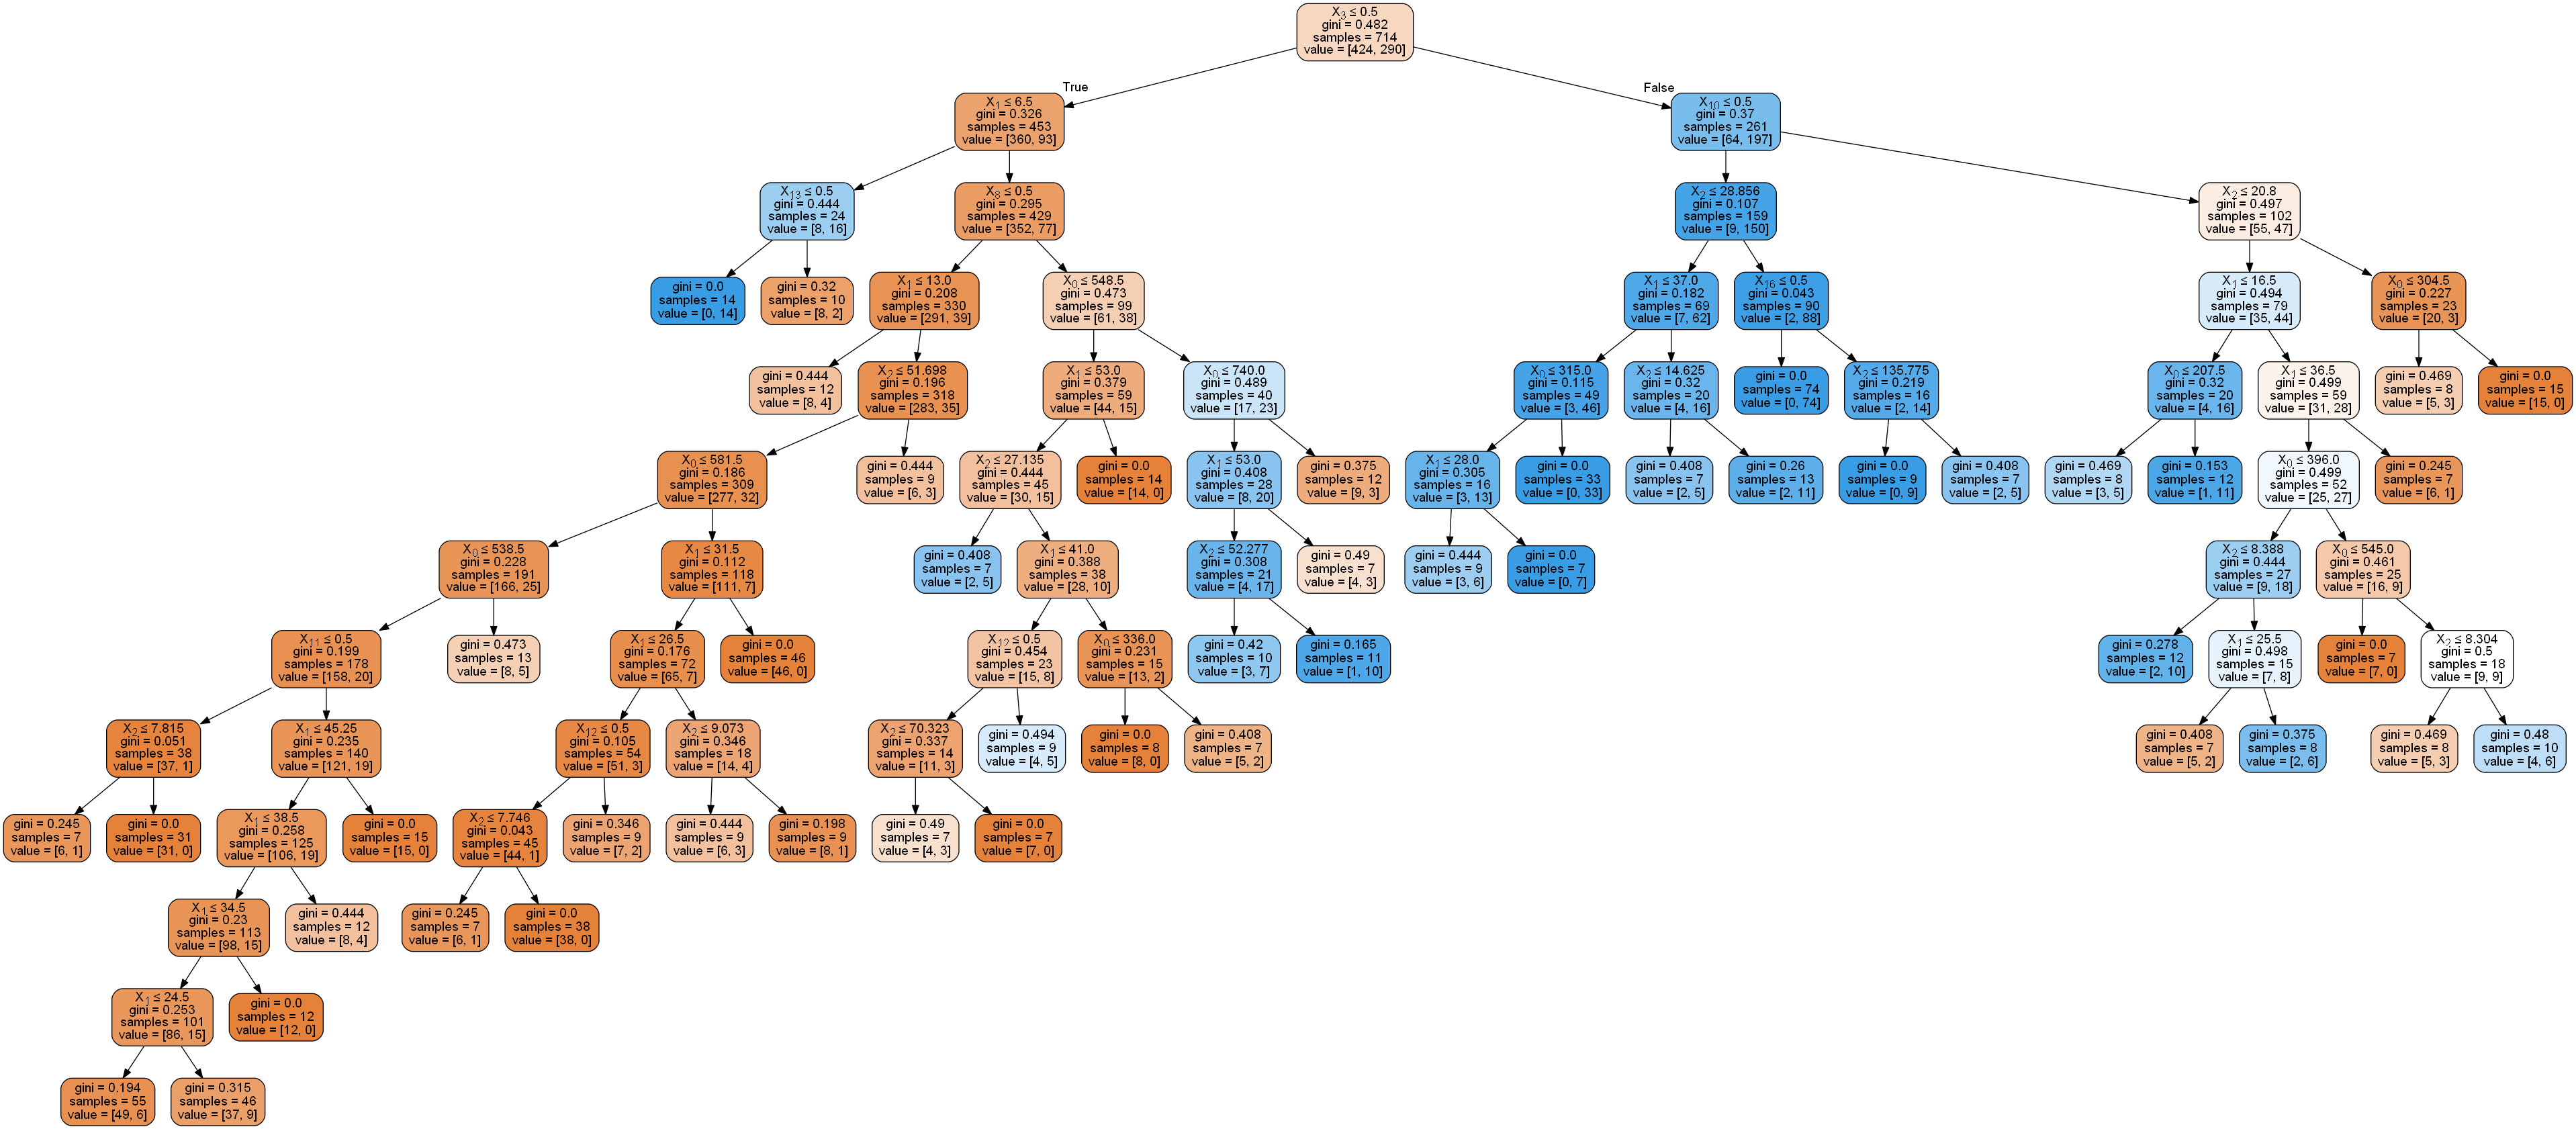

In [232]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### подготовим тектовые данные для прогноза

In [185]:
# проведем предварительную подготовку
test_df['title']=test_df.Name.apply(check_title)
test_df['Parch_cat']=test_df.Parch.apply(group_Parch)
test_df['SibSp_cat']=test_df.SibSp.apply(group_SibSp)

temp_df=test_df[['Sex', 'Embarked','Pclass', 'SibSp_cat', 'Parch_cat']].copy()
temp_df['Pclass']=temp_df['Pclass'].astype(object)
temp_df['SibSp_cat']=temp_df['SibSp_cat'].astype(object)
temp_df['Parch_cat']=temp_df['Parch_cat'].astype(object)
temp_df=pd.get_dummies(temp_df)
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
Sex_female         418 non-null uint8
Sex_male           418 non-null uint8
Embarked_C         418 non-null uint8
Embarked_Q         418 non-null uint8
Embarked_S         418 non-null uint8
Pclass_1           418 non-null uint8
Pclass_2           418 non-null uint8
Pclass_3           418 non-null uint8
SibSp_cat_0        418 non-null uint8
SibSp_cat_1        418 non-null uint8
SibSp_cat_other    418 non-null uint8
Parch_cat_0        418 non-null uint8
Parch_cat_1        418 non-null uint8
Parch_cat_2        418 non-null uint8
Parch_cat_other    418 non-null uint8
dtypes: uint8(15)
memory usage: 6.2 KB


In [186]:
test_df.Age.fillna(train.Age.median(), inplace=True)
test_df.Fare.fillna(train.Fare.median(), inplace=True)
test=pd.concat([test_df[['PassengerId', 'Age', 'Fare']], temp_df], axis=1)

In [187]:
y_test_pred=tree.predict(test)
y_test_pred[:10]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int64)

In [195]:
submit=pd.DataFrame(test_df.PassengerId)
submit['Survived']=y_test_pred
submit.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [208]:
submit.to_csv('HOMEWORKS/submissions/submit_titanic_280719.csv',index=False)

# результат на Kaggle

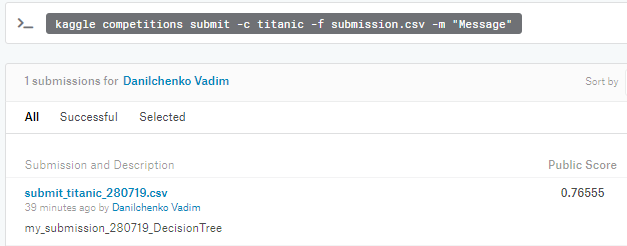

In [235]:
Image(filename = "HOMEWORKS/submissions/submission screenshot_titanic_280719.PNG", width=1000, height=100)